# Customer segmentation of the Olist E-Commerce site

## Context
 - Olist is the largest e-commerce platform in Brazilian online marketplaces that connects and offers a solution for buying and selling on online. 
 - Olist wants to obtain a segmentation of its customers that their marketing team can use in their daily communication campaigns. 
 - The dataset provided by has information of ~100k orders from 2016 to 2018 made at multiple marketplaces. 

## Goal:
 - To understand the different types of users through their behavior and anonymized personal data.

## Objectives:
 My mission is to to help Olist teams understand the different types of users. Thus, I will use unsupervised methods to:
 - provide an actionable description of segmentation and its underlying logic for optimal use. 
 - provide an analysis of the stability of the segments over time in order to establish a maintenance contract.
 - group together customers with similar profiles that can be used by the marketing team to better communicate.

### Part 3
 - **Segment stability and contract maintenance**
  - In order to establish a maintenance contract for the customer segmentation algorithm, we need to test its stability over time and see, for example, when customers change clusters. To do this, we need to recalculate all the features according to a given period. 

## 1.0 Import Libraries

In [1]:
import pandas as pd # for data loading, manipulation, and exploration
import numpy as np # for linear algebra/vector arithmetic
from datetime import datetime as dt # Handling dates and timestamps
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn import metrics, cluster

# statistical data visualization
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib.ticker import (MultipleLocator,FormatStrFormatter, AutoMinorLocator)

import warnings
warnings.filterwarnings('ignore')

### 2.0 Load dataset

In [2]:
# import Client_dataset
Data = pd.read_csv("Command_df2.csv")

# read the dataset
Data.head(5)

,customer_unique_id,order_id,price,freight_value,payment_value,payment_installments,payment_sequential,review_score,purchase_year,purchase_month,last_purchase,delivery_days,delayed_delivery,distance(km)
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,124.99,21.88,146.87,2.0,1.0,4.0,2017.0,5.0,474,8.0,0.0,348.87
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,289.00,46.48,335.48,8.0,1.0,5.0,2018.0,1.0,233,16.0,0.0,413.95
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,139.94,17.79,157.73,7.0,1.0,5.0,2018.0,5.0,106,26.0,1.0,29.97
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,149.94,23.36,173.30,1.0,1.0,5.0,2018.0,3.0,173,14.0,0.0,18.57
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,230.00,22.25,252.25,8.0,1.0,5.0,2018.0,7.0,35,11.0,0.0,220.11


In [3]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94019 entries, 0 to 94018
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_unique_id    94019 non-null  object 
 1   order_id              94019 non-null  object 
 2   price                 94019 non-null  float64
 3   freight_value         94019 non-null  float64
 4   payment_value         94019 non-null  float64
 5   payment_installments  94019 non-null  float64
 6   payment_sequential    94019 non-null  float64
 7   review_score          94019 non-null  float64
 8   purchase_year         94019 non-null  float64
 9   purchase_month        94019 non-null  float64
 10  last_purchase         94019 non-null  int64  
 11  delivery_days         94019 non-null  float64
 12  delayed_delivery      94019 non-null  float64
 13  distance(km)          94019 non-null  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 10.0+ MB


### 3.0 Create data files and build models

 - To determine when customers change clusters, we will iterate the K-Means over the whole period with an interval of 15 days and calculate the ARI score, taking care to compare the same customers (those of the initial 12 months). 
 

 - Here, I iterate the K-Means cluster two times using at an initial periods of December 31, 2017 and April, 30 2018, first on on the RFM features and second on the RFM + other features used for the clustering and segmentation.
 
 
 - I used RobustScaler to manage skew features

#### 3.1 Customers RFM file

In [4]:
Data_RFM = Data[['customer_unique_id','order_id', 'payment_value', 'last_purchase', 'purchase_month', 'purchase_year']]

#Rename columns
Data_RFM.rename(columns={'last_purchase':'Recency', 'order_id': 'Frequency', 'payment_value': 'Monetary'}, inplace=True)
Data_RFM

,customer_unique_id,Frequency,Monetary,Recency,purchase_month,purchase_year
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,146.87,474,5.0,2017.0
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,335.48,233,1.0,2018.0
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,157.73,106,5.0,2018.0
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,173.30,173,3.0,2018.0
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,252.25,35,7.0,2018.0
...,...,...,...,...,...,...
94014,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,88.78,148,4.0,2018.0
94015,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,129.06,152,4.0,2018.0
94016,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,56.04,147,4.0,2018.0
94017,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,711.07,303,11.0,2017.0


#### First Simulation
 - 4 clusters for RFM features

***at initial date (T0)***
- Use Jan 01 to Dec 31 2017 as the initial file

In [5]:
# Select all orders in 2017 as initial client_file
F_start = Data_RFM[Data_RFM['purchase_year'] == 2017.0]

F0 = F_start.groupby('customer_unique_id').agg({'Recency':'min', 'Frequency':'count', 'Monetary': 'sum'}).reset_index()
F0 = F0.drop('customer_unique_id', axis = 1)

# Standardize features, instantiate and fit the model the initial period on 4 clusters
numerical_features = list(F0.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
Km = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

M0 = Km_pipe.fit(F0)
#fit the model
C0 = M0.fit(F0)

***at T1 = T0 + 15 days (15 days period)***

In [6]:
# Using a 15 days interval to create each files, T1 = T0 + 15 days = T1(Recency) - 15

F0_max = F0['Recency'].max()
dT1 = 15
dF1 = F0['Recency'].min() - dT1 # negative because recency decreases in days with increasing date
F_T1= Data_RFM[(Data_RFM['Recency'] >= dF1) & (Data_RFM['Recency'] <= F0_max)]
F1 = F_T1.groupby('customer_unique_id').agg({'Recency':'min', 'Frequency':'count', 'Monetary': 'sum'}).reset_index()
F1.drop('customer_unique_id', axis = 1, inplace = True)

#Instantiate and fit the model the initial period 
# Standardize features, instantiate and fit the model the initial period on 4 clusters
numerical_features = list(F1.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
Km = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

# Fit the model
M1= Km_pipe.fit(F1)
C1 = M1.fit(F1)

#get the initial clusters
C1_init = M0.predict(F1) 
C1_pred = M1.predict(F1)
ari_pred = adjusted_rand_score(C1_init, C1_pred)
ari_pred

0.9167474440747094

***at T2 = T1 + 15 days (15 days period)***

In [7]:
# Using a 15 days interval to create each files, T2 = T1 + 15 days = T1(Recency) - 15

#F0_i = F0['Recency'].max()
dT2 = 30
dF2 = F0['Recency'].min() - dT2
F_T2= Data_RFM[(Data_RFM['Recency'] >= dF2) & (Data_RFM['Recency'] <= F0_max)]
F2 = F_T2.groupby('customer_unique_id').agg({'Recency':'min', 'Frequency':'count', 'Monetary': 'sum'}).reset_index()
F2.drop('customer_unique_id', axis = 1, inplace = True)

#Instantiate and fit the model the initial period 
# Standardize features, instantiate and fit the model the initial period on 4 clusters
numerical_features = list(F2.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
Km = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

# Fit the model
M2= Km_pipe.fit(F2)
C2 = M2.fit(F2)

#get the initial clusters
C2_init = M0.predict(F2) #M0.named_steps['kmeans'].labels_
C2_pred = M2.predict(F2)
ari_pred = adjusted_rand_score(C2_init, C2_pred)
ari_pred

0.9890792773033719

at T3 = T2 + 15 days (15 days period)

In [8]:
F0_max = F0['Recency'].max()
dT3 = 45
dF3 = F0['Recency'].min() - dT3
F_T3 = Data_RFM[(Data_RFM['Recency'] >= dF3) & (Data_RFM['Recency'] <= F0_max)]
F3 = F_T3.groupby('customer_unique_id').agg({'Recency':'min', 'Frequency':'count', 'Monetary': 'sum'}).reset_index()
F3 = F3.drop('customer_unique_id', axis = 1)
    
numerical_features = list(F3.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])

# create Kmeans model
Km = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)

# make a pipeline chaining the column transformer and Kmeans
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])
    
    
M3 = Km_pipe.fit(F3)
C3 = M3.fit(F3) 
    
C3_init = M0.predict(F3)
C3_pred = M3.predict(F3)
ari_pred = adjusted_rand_score(C3_init, C3_pred)
ari_pred

0.9982598284926082

***Total period (in days) covered from January  to August 2018***
   - T0 + n_days

In [9]:
def Simulation_RFM(period):
    F0_max = F0['Recency'].max()
    start = F0['Recency'].min()
    Fi = Data_RFM[(Data_RFM['Recency'] >= (start - period)) & (Data_RFM['Recency'] <= F0_max)]
    Fi = Fi.groupby('customer_unique_id').agg({'Recency':'min', 'Frequency':'count', 'Monetary': 'sum'}).reset_index()
    Fi = Fi.drop('customer_unique_id', axis = 1)
    
    numerical_features = list(Fi.columns)
    preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
    Km = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
    Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])
    
    
    Mi = Km_pipe.fit(Fi)
    Ci = Mi.fit(Fi) 
    
    Ci_init = M0.predict(Fi)
    Ci_pred = Mi.predict(Fi)
    
    # calculate ARI score
    ari_pred = adjusted_rand_score(Ci_init, Ci_pred)
    return ari_pred      

***Period of coverage (January to August 2018)***

In [10]:
# from Jan 1 to August 2018
F_2018 = Data_RFM[Data_RFM['purchase_year'] == 2018.0] # select 2018 customer files
period_2018 = F_2018['Recency'].max() - F_2018['Recency'].min()
print(f"Total number of days covered from January to August 2018 is: {period_2018} days")

Total number of days covered from January to August 2018 is: 241 days


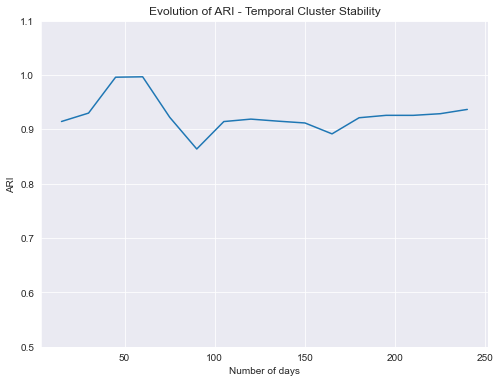

In [11]:
period = np.arange(15, 255, 15) # 15 days interval
ari_score = []

for x in period:
    ari_pred = Simulation_RFM(x)
    ari_score.append([x, ari_pred])

ari_score_df = pd.DataFrame(ari_score, columns=["period", "ARI"])

sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
sns.lineplot(data=ari_score_df, x="period", y="ARI")
#plt.plot(period,ari_pred)
plt.xlabel('Number of days')
plt.title("Evolution of ARI - Temporal Cluster Stability")
plt.ylabel('ARI')
plt.ylim(0.5,1.1, 0.1)
plt.show()

#### Second Simulation
- to further explore the temporal stability of the cluster at another initial period

***at initial date (T0) of April, 30 2018***

In [12]:
Data_RFM_2 = Data_RFM[Data_RFM['purchase_year'] > 2016.0]
F_SS = Data_RFM_2[~((Data_RFM_2['purchase_year'] == 2018.0) & (Data_RFM_2['purchase_month'] > 4.0))]
#F_SS = F_SS[F_SS['purchase_year'] > 2016.0] #  - 2017 to April 30, 2018 files
F_SS.head()

,customer_unique_id,Frequency,Monetary,Recency,purchase_month,purchase_year
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,146.87,474,5.0,2017.0
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,335.48,233,1.0,2018.0
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,173.30,173,3.0,2018.0
5,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,282.21,353,9.0,2017.0
6,addec96d2e059c80c30fe6871d30d177,36e694cf4cbc2a4803200c35e84abdc4,22.77,195,2.0,2018.0


In [13]:
F_SS['Recency'].min()

125

In [14]:
F_SS['Recency'].max()

605

In [15]:
F0_2 = F_SS.groupby('customer_unique_id').agg({'Recency':'min', 'Frequency':'count', 'Monetary': 'sum'}).reset_index()
F0_2.drop('customer_unique_id', axis = 1, inplace = True)

# Standardize features, instantiate and fit the model the initial period on 4 clusters
numerical_features = list(F0_2.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
Km = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

M0_2 = Km_pipe.fit(F0_2)
#fit the model
C0_2 = M0.fit(F0_2)

***T1 = T0 + 15***

In [16]:
F02_max = F_SS['Recency'].max()
dT1 = 15
dF1_SS = F0['Recency'].min()-dT1
F_T1SS= Data_RFM_2[(Data_RFM_2['Recency'] >= dF1_SS) & (Data_RFM_2['Recency'] <= F02_max)]
F1 = F_T1SS.groupby('customer_unique_id').agg({'Recency':'min', 'Frequency':'count', 'Monetary': 'sum'}).reset_index()
F1.drop('customer_unique_id', axis = 1, inplace = True)

#Instantiate and fit the model the initial period 
# Standardize features, instantiate and fit the model the initial period on 4 clusters
numerical_features = list(F1.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
Km = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

# Fit the model
M1= Km_pipe.fit(F1)
C1 = M1.fit(F1)
#get the initial clusters
C1_init = M0.predict(F1) #M0.named_steps['kmeans'].labels_
C1_pred = M1.predict(F1)
ari_pred = adjusted_rand_score(C1_init, C1_pred)
ari_pred

0.9976990559073033

***T2 = T1 + 15***

In [17]:
#F0_i = F0['Recency'].max()
dT_SS = 30
dF2_SS = F0['Recency'].min()-dT_SS
F2= Data_RFM_2[(Data_RFM_2['Recency'] >= dF2_SS) & (Data_RFM_2['Recency'] <= F02_max)]
F2 = F2.groupby('customer_unique_id').agg({'Recency':'min', 'Frequency':'count', 'Monetary': 'sum'}).reset_index()
F2.drop('customer_unique_id', axis = 1, inplace = True)

#Instantiate and fit the model the initial period 
# Standardize features, instantiate and fit the model the initial period on 4 clusters
numerical_features = list(F2.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
Km = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

# Fit the model
M2= Km_pipe.fit(F2)
C2 = M2.fit(F2)

#get the initial clusters
C2_init = M0.predict(F2) #M0.named_steps['kmeans'].labels_
C2_pred = M2.predict(F2)
ari_pred = adjusted_rand_score(C2_init, C2_pred)
ari_pred

0.9144891032747069

In [18]:
def Simulation_RFM(period):
    F02_max = F0['Recency'].max()
    start = F0['Recency'].min()
    Fi = Data_RFM_2[(Data_RFM_2['Recency'] >= (start-period)) & (Data_RFM_2['Recency'] <= F02_max)]
    Fi = Fi.groupby('customer_unique_id').agg({'Recency':'min', 'Frequency':'count', 'Monetary': 'sum'}).reset_index()
    Fi = Fi.drop('customer_unique_id', axis = 1)
    
    numerical_features = list(Fi.columns)
    preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
    Km = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
    Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])
    
    
    Mi = Km_pipe.fit(Fi)
    Ci = Mi.fit(Fi) 
    
    Ci_init = M0.predict(Fi)
    Ci_pred = Mi.predict(Fi)
    
    ari_pred = adjusted_rand_score(Ci_init, Ci_pred)
    return ari_pred      

In [19]:
# from May 1 to August 2018
period_May = F_2018[F_2018['purchase_month'] >4]
days = period_May['Recency'].max() - period_May['Recency'].min()
print(f"Total number of days covered from May to August 2018 is: {days} days")

Total number of days covered from May to August 2018 is: 121 days


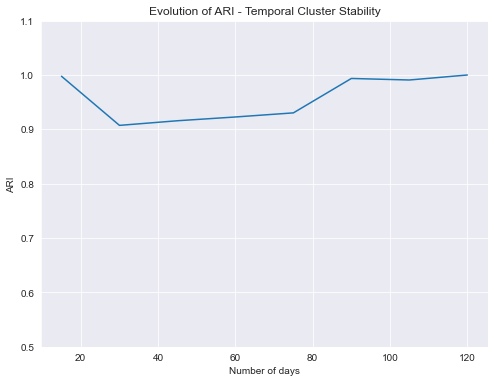

In [20]:
period = np.arange(15, 121, 15) # 15 days interval
ari_score = []

for x in period:
    ari_pred = Simulation_RFM(x)
    ari_score.append([x, ari_pred])

ari_score_df = pd.DataFrame(ari_score, columns=["period", "ARI"])

sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
sns.lineplot(data=ari_score_df, x="period", y="ARI")
plt.xlabel('Number of days')
plt.title("Evolution of ARI - Temporal Cluster Stability")
plt.ylabel('ARI')
plt.ylim(0.5,1.1, 0.1)
plt.show()

### 3.2 Customers RFM + other features 
 - applying 5 clusters

In [21]:
# Get data
lst = ['price', 'freight_value', 'delayed_delivery', 'payment_sequential']
Data_features = Data.drop(lst, axis = 1)
Data_features.head()

,customer_unique_id,order_id,payment_value,payment_installments,review_score,purchase_year,purchase_month,last_purchase,delivery_days,distance(km)
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,146.87,2.0,4.0,2017.0,5.0,474,8.0,348.87
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,335.48,8.0,5.0,2018.0,1.0,233,16.0,413.95
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,157.73,7.0,5.0,2018.0,5.0,106,26.0,29.97
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,173.30,1.0,5.0,2018.0,3.0,173,14.0,18.57
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,252.25,8.0,5.0,2018.0,7.0,35,11.0,220.11


#### First Simulation

***at Initial T = 0 (December 31, 2017)***

In [22]:
DF_F0 = Data_features[Data_features['purchase_year'] == 2017.0]
DF_F0.head()

,customer_unique_id,order_id,payment_value,payment_installments,review_score,purchase_year,purchase_month,last_purchase,delivery_days,distance(km)
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,146.87,2.0,4.0,2017.0,5.0,474,8.0,348.87
5,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,282.21,1.0,5.0,2017.0,9.0,353,13.0,409.47
9,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,40.40,1.0,5.0,2017.0,11.0,279,11.0,775.66
11,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,117.31,1.0,4.0,2017.0,9.0,358,11.0,227.38
17,3e6fd6b2f0d499456a6a6820a40f2d79,ab797176e01c2fa3d13aa1fe3e63d9ee,54.62,5.0,4.0,2017.0,11.0,305,30.0,2237.65


In [23]:
#Select all orders in 2017 as initial client_file
F0 = DF_F0.groupby('customer_unique_id').agg({'order_id':'count', 'payment_value': 'sum','review_score': 'mean', 
                        'last_purchase':'min', 'payment_installments':'mean', 'delivery_days':'mean', 
                                           'distance(km)':'mean'}).reset_index()
F0.drop('customer_unique_id', axis = 1, inplace = True)

#Instantiate and fit the model the initial period on 5 clusters
numerical_features = list(F0.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
Km = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

M0 = Km_pipe.fit(F0)
#fit the model
C0 = M0.fit(F0)

***at T1 = T0+15 days***

In [24]:
# Using a 15 days interval to create each files, T1 = T0 + 15 days = T1(Recency) - 15

F0_max2 = F0['last_purchase'].max()
dT_1 = 15
dF_1 = F0['last_purchase'].min()-dT_1
F_T1= Data_features[(Data_features['last_purchase'] >= dF_1) & (Data_features['last_purchase'] <= F0_max2)]
F1 = F_T1.groupby('customer_unique_id').agg({'order_id':'count', 'payment_value': 'sum','review_score': 'mean', 
                        'last_purchase':'min', 'payment_installments':'mean', 'delivery_days':'mean', 
                                           'distance(km)':'mean'}).reset_index()

F1.drop('customer_unique_id', axis = 1, inplace = True)

#Instantiate and fit the model the initial period 
numerical_features = list(F1.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
Km = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

# Fit the model
M1= Km_pipe.fit(F1)
C1 = M1.fit(F1)

#get the initial clusters
C1_init = M0.predict(F1) #M0.named_steps['kmeans'].labels_
C1_pred = M1.predict(F1)
ari_pred = adjusted_rand_score(C1_init, C1_pred)
ari_pred

0.9981684281824182

***at T2 = T1 + 15 days (15 days period)***

In [25]:
F0_max2 = F0['last_purchase'].max()
dT2 = 30
dF2 = F0['last_purchase'].min()-dT2
F_T2= Data_features[(Data_features['last_purchase'] >= dF2) & (Data_features['last_purchase'] <= F0_max2)]
F2 = F_T2.groupby('customer_unique_id').agg({'order_id':'count', 'payment_value': 'sum','review_score': 'mean', 
                        'last_purchase':'min', 'payment_installments':'mean', 'delivery_days':'mean', 
                                           'distance(km)':'mean'}).reset_index()
F2.drop('customer_unique_id', axis = 1, inplace = True)

#Instantiate and fit the model the initial period 
numerical_features = list(F2.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
Km = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

# Fit the model
M2= Km_pipe.fit(F2)
C2 = M2.fit(F2)

#get the initial clusters
C2_init = M0.predict(F2) #M0.named_steps['kmeans'].labels_
C2_pred = M2.predict(F2)
ari_pred = adjusted_rand_score(C2_init, C2_pred)
ari_pred

0.9963751208453178

***at Ti = T0 + n days***

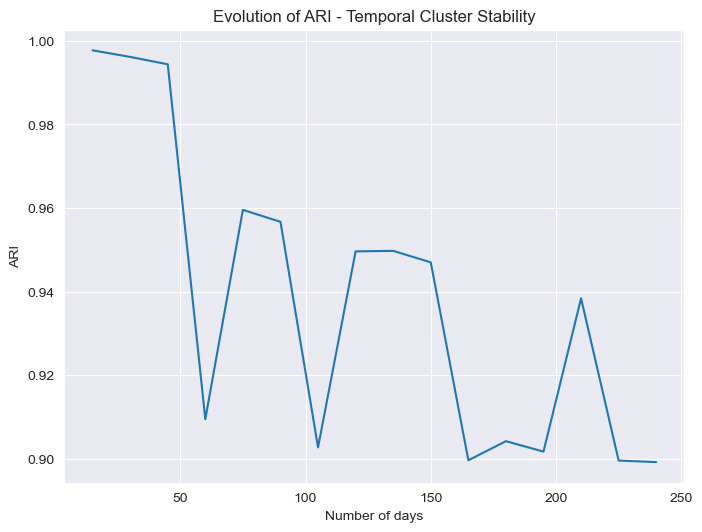

In [26]:
def Simulation_Others(period):
    F0_maxi = F0['last_purchase'].max()
    start = F0['last_purchase'].min()
    Fi = Data_features[(Data_features['last_purchase'] >= (start-period)) & (Data_features['last_purchase'] <= F0_maxi)]
    Fi = Fi.groupby('customer_unique_id').agg({'order_id':'count', 'payment_value': 'sum','review_score': 'mean', 
                        'last_purchase':'min', 'payment_installments':'mean', 'delivery_days':'mean', 
                                               'distance(km)':'mean'}).reset_index()
    Fi = Fi.drop('customer_unique_id', axis = 1)
    
    numerical_features = list(F0.columns)
    preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
    Km = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
    Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

        
    Mi = Km_pipe.fit(Fi)
    Ci = Mi.fit(Fi) 
    
    Ci_init = M0.predict(Fi)
    Ci_pred = Mi.predict(Fi)
    
    ari_pred = adjusted_rand_score(Ci_init, Ci_pred)
    return ari_pred       

# Get ARI and plot against period
period = np.arange(15, 255, 15) # 15 days interval
ari_score = []

for x in period:
    ari_pred = Simulation_Others(x)
    ari_score.append([x, ari_pred])

ari_score_df = pd.DataFrame(ari_score, columns=["period", "ARI"])

sns.set_style('darkgrid')
plt.figure(figsize=(8,6), dpi = 100)
sns.lineplot(data=ari_score_df, x="period", y="ARI")
plt.xlabel('Number of days')
plt.title("Evolution of ARI - Temporal Cluster Stability")
plt.ylabel('ARI')
#plt.ylim(0.5,1.1, 0.1)
plt.show()

#### Second Simulations

at initial date (T0) of April, 30 2018

In [27]:
# drop 2016 data
Data_features_2 = Data_features[Data_features['purchase_year'] > 2016.0]

 #  - 2017 to April 30, 2018 files
feat_df = Data_features_2[~((Data_features_2['purchase_year'] == 2018.0) & (Data_features_2['purchase_month'] > 4.0))]
 
feat_df.head()

,customer_unique_id,order_id,payment_value,payment_installments,review_score,purchase_year,purchase_month,last_purchase,delivery_days,distance(km)
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,146.87,2.0,4.0,2017.0,5.0,474,8.0,348.87
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,335.48,8.0,5.0,2018.0,1.0,233,16.0,413.95
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,173.30,1.0,5.0,2018.0,3.0,173,14.0,18.57
5,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,282.21,1.0,5.0,2017.0,9.0,353,13.0,409.47
6,addec96d2e059c80c30fe6871d30d177,36e694cf4cbc2a4803200c35e84abdc4,22.77,1.0,5.0,2018.0,2.0,195,1.0,4.27


In [28]:
feat_df['last_purchase'].min()

125

In [29]:
feat_df['last_purchase'].max()

605

In [30]:
F0_2S = feat_df.groupby('customer_unique_id').agg({'order_id':'count', 'payment_value': 'sum','review_score': 'mean', 
                        'last_purchase':'min', 'payment_installments':'mean', 'delivery_days':'mean', 
                                           'distance(km)':'mean'}).reset_index()
F0_2S.drop('customer_unique_id', axis = 1, inplace = True)

#Instantiate and fit the model the initial period on 5 clusters
numerical_features = list(F0_2S.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
Km = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

M0 = Km_pipe.fit(F0_2S)
#fit the model
C0 = M0.fit(F0_2S)

***at T1 = T0+15 days***

In [31]:
F0_2Smax = F0_2S['last_purchase'].max()
dT1 = 15
dFT1 = F0_2S['last_purchase'].min() - dT1
F1_2S= feat_df[(feat_df['last_purchase'] >= dFT1) & (feat_df['last_purchase'] <= F0_2Smax)]
F1T1 = F1_2S.groupby('customer_unique_id').agg({'order_id':'count', 'payment_value': 'sum','review_score': 'mean', 
                        'last_purchase':'min', 'payment_installments':'mean', 
            'delivery_days':'mean', 'distance(km)':'mean'}).reset_index()
F1T1.drop('customer_unique_id', axis = 1, inplace = True)

#Instantiate and fit the model the initial period 
numerical_features = list(F1T1.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
Km = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

# Fit the model
M1= Km_pipe.fit(F1T1)
C1 = M1.fit(F1T1)

#get the initial clusters
C1_init = M0.predict(F1T1) #M0.named_steps['kmeans'].labels_
C1_pred = M1.predict(F1T1)
ari_pred = adjusted_rand_score(C1_init, C1_pred)
ari_pred

1.0

In [32]:
dT2 = 30
dFT2 = F0_2S['last_purchase'].min()-dT2
F2_2S= feat_df[(feat_df['last_purchase'] >= dFT2) & (feat_df['last_purchase'] <= F0_2Smax)]
F2T2 = F2_2S.groupby('customer_unique_id').agg({'order_id':'count', 'payment_value': 'sum','review_score': 'mean', 
                        'last_purchase':'min', 'payment_installments':'mean', 
            'delivery_days':'mean', 'distance(km)':'mean'}).reset_index()
F2T2.drop('customer_unique_id', axis = 1, inplace = True)

#Instantiate and fit the model the initial period 
numerical_features = list(F2T2.columns)
preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
Km = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])


# Fit the model
M2= Km_pipe.fit(F2T2)
C2 = M2.fit(F2T2)

#get the initial clusters
C2_init = M0.predict(F2T2) #M0.named_steps['kmeans'].labels_
C2_pred = M2.predict(F2T2)
ari_pred = adjusted_rand_score(C2_init, C2_pred)
ari_pred

1.0

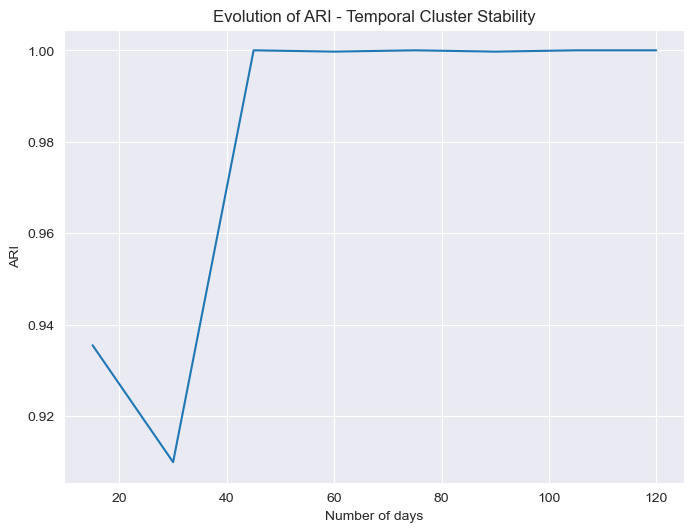

In [33]:
def Simulation_Others2(period):
    F0_2max = F0_2S['last_purchase'].max()
    start = F0_2S['last_purchase'].min()
    Fi_nth = feat_df[(feat_df['last_purchase'] >= (start-period)) & (feat_df['last_purchase'] <= F0_2max)]
    Fi_2S = Fi_nth.groupby('customer_unique_id').agg({'order_id':'count', 'payment_value': 'sum','review_score': 'mean', 
                        'last_purchase':'min', 'payment_installments':'mean', 'delivery_days':'mean', 
                                               'distance(km)':'mean'}).reset_index()
    Fi_2S = Fi_2S.drop('customer_unique_id', axis = 1)
    
    numerical_features = list(Fi_2S.columns)
    preprocessor = ColumnTransformer([('scaler', RobustScaler(), numerical_features)])
    Km = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter = 500, random_state=None, verbose=0)
    Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])

        
    Mi = Km_pipe.fit(Fi_2S)
    Ci = Mi.fit(Fi_2S) 
    
    Ci_init = M0.predict(Fi_2S)
    Ci_pred = Mi.predict(Fi_2S)
    
    ari_pred = adjusted_rand_score(Ci_init, Ci_pred)
    return ari_pred       

# Get ARI and plot against period
period = np.arange(15, 121, 15) # 15 days interval
ari_score = []

for x in period:
    ari_pred = Simulation_Others2(x)
    ari_score.append([x, ari_pred])

ari_score_df = pd.DataFrame(ari_score, columns=["period", "ARI"])

sns.set_style('darkgrid')
plt.figure(figsize=(8,6), dpi = 100)
sns.lineplot(data=ari_score_df, x="period", y="ARI")
plt.xlabel('Number of days')
plt.title("Evolution of ARI - Temporal Cluster Stability")
plt.ylabel('ARI')
#plt.ylim(0.5,1.1, 0.1)
plt.show()

In [34]:
ari_score_df

,period,ARI
0,15,0.935520
1,30,0.909970
2,45,1.000000
3,60,0.999713
4,75,1.000000
5,90,0.999713
6,105,1.000000
7,120,1.000000


***Conclusion***
 - The plots of the ARI scores obtained on the iterations per 15 days period show varying points of inflexions on the RFM and RFM + other features. The clusters are relatively stable in most of the plots (ARI > 0.8), except in the last plot where we notice a strong point of inflexion (ARI < 0.8) after 60 days (2 months) of the initial clients of April 31, 2018 on the RFM+other feature plots. This 60 days period is somehow consistent with the minor inflexion points on the other plots. Therefore, it is advised to maintain the segmentation program and cluster maintainance every 2 months and test the temporal stability of the cluster over time for improvements.  